(howto_debugging)=
# How to debug a model

:::{post} August 2, 2022
:tags: debugging, PyTensor
:category: beginner
:author: Thomas Wiecki, Igor Kuvychko
:::

## Introduction
There are various levels on which to debug a model. One of the simplest is to just print out the values that different variables are taking on.

Because `PyMC` uses `PyTensor` expressions to build the model, and not functions, there is no way to place a `print` statement into a likelihood function. Instead, you can use the {class}`pytensor.printing.Print` class to print intermediate values. In PyMC we have `print_values` helper function to print intermediate values. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927

### How to print intermediate values of `PyTensor` functions
Since `PyTensor` functions are compiled to C, you have to use `pymc.pytensorf.print_value` function to print intermediate values. Python `print` function will not work. Below is a simple example of using `print_value`. For more information, see {ref}`Debugging PyTensor <pytensor:debug_faq>`.

In [3]:
import pytensor.tensor as pt

from pymc.pytensorf import print_value
from pytensor import function

In [4]:
x = pt.dvector("x")
y = pt.dvector("y")
func = function([x, y], 1 / (x - y))
func([1, 2, 3], [1, 0, -1])

array([ inf, 0.5 , 0.25])

To see what causes the `inf` value in the output, we can print intermediate values of $(x-y)$ using `print_value`. `print_value` is based on the {class}`pytensor.prinitng.Print` class that simply passes along its caller but prints out its value along a user-define message:

In [5]:
z_with_print = print_value(x - y, "x - y = ")
func_with_print = function([x, y], 1 / z_with_print)
func_with_print([1, 2, 3], [1, 0, -1])

x - y =  __str__ = [0. 2. 4.]


array([ inf, 0.5 , 0.25])

`print_value` reveals the root cause: $(x-y)$ takes a zero value when $x=1, y=1$, causing the `inf` output.

### How to capture `print_values` output for further analysis

When we expect many rows of output from `print_values`, it can be desirable to redirect the output to a string buffer and access the values later on (thanks to **Lindley Lentati** for inspiring this example). Here is a toy example using Python `print` function:

In [6]:
import sys

from io import StringIO

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

for i in range(5):
    print(f"Test values: {i}")

output = mystdout.getvalue().split("\n")
sys.stdout = old_stdout  # setting sys.stdout back
output

['Test values: 0',
 'Test values: 1',
 'Test values: 2',
 'Test values: 3',
 'Test values: 4',
 '']

### Troubleshooting a toy PyMC model

In [7]:
rng = np.random.default_rng(RANDOM_SEED)
x = rng.normal(size=100)

with pm.Model() as model:
    # priors
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.Normal("sd", mu=0, sigma=1)

    # setting out printing for mu and sd
    mu_print = print_value(mu)
    sd_print = print_value(sd)

    # likelihood
    obs = pm.Normal("obs", mu=mu_print, sigma=sd_print, observed=x)

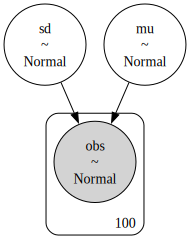

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5, step, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

TypeError: sample() takes from 0 to 1 positional arguments but 2 positional arguments (and 4 keyword-only arguments) were given

Exception handling of PyMC v4 has improved, so now SamplingError exception prints out the intermediate values of `mu` and `sd` which led to likelihood of `-inf`. However, this technique of printing intermediate values with `aeasara.printing.Print` can be valuable in more complicated cases.

### Bringing it all together

In [10]:
rng = np.random.default_rng(RANDOM_SEED)
y = rng.normal(loc=5, size=20)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    a = pm.Normal("a", mu=0, sigma=10, initval=0.1)
    b = pm.Normal("b", mu=0, sigma=10, initval=0.1)
    sd_print = print_value(a / b, name="Delta")
    obs = pm.Normal("obs", mu=mu, sigma=sd_print, observed=y)

    # limiting number of samples and chains to simplify output
    trace = pm.sample(draws=10, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

output = mystdout.getvalue()
sys.stdout = old_stdout  # setting sys.stdout back

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, a, b]
Sampling 1 chain for 0 tune and 10 draw iterations (0 + 10 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.


In [11]:
output

'Delta __str__ = -85.74093608165128\nDelta __str__ = -9.182002291671038\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315734173890057\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.312485782438435\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.314669656412734\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.31581619157038\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.31511471913361\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315110404793872\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.314077394936474\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.313673830463394\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315610253397129\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315265693700571\n'

Raw output is a bit messy and requires some cleanup and formatting to convert to {ref}`numpy.ndarray`. In the example below regex is used to clean up the output, and then it is evaluated with `eval` to give a list of floats. Code below also works with higher-dimensional outputs (in case you want to experiment with different models).

In [12]:
import re

# output cleanup and conversion to numpy array
# this is code accepts more complicated inputs
pattern = re.compile("Delta __str__ = ")
output = re.sub(pattern, " ", output)
pattern = re.compile("\\s+")
output = re.sub(pattern, ",", output)
pattern = re.compile(r"\[,")
output = re.sub(pattern, "[", output)
output += "]"
output = "[" + output[1:]
output = eval(output)
output = np.array(output)

In [13]:
output

array([-85.74093608,  -9.18200229,   0.10737295,   0.10737295,
         0.10737295,  -9.31573417,   0.10737295,  -9.31248578,
         0.10737295,  -9.31466966,   0.10737295,  -9.31581619,
         0.10737295,  -9.31511472,   0.10737295,  -9.3151104 ,
         0.10737295,  -9.31407739,   0.10737295,  -9.31367383,
         0.10737295,  -9.31561025,   0.10737295,  -9.31526569])

Notice that we requested 5 draws, but got 34 sets of $a/b$ values. The reason is that for each iteration, all proposed values are printed (not just the accepted values). Negative values are clearly problematic.

In [14]:
output.shape

(24,)

## Authors

* Authored by Thomas Wiecki in July, 2016
* Updated by Igor Kuvychko in August, 2022 ([pymc#406] (https://github.com/pymc-devs/pymc-examples/pull/406))

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Mon Feb 12 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

pytensor: 2.18.6
xarray  : 2024.1.1

pandas    : 2.2.0
re        : 2.2.1
arviz     : 0.17.0
sys       : 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:27:59) [MSC v.1937 64 bit (AMD64)]
pymc      : 0+untagged.9733.g94020c9.dirty
pytensor  : 2.18.6
matplotlib: 3.8.2
numpy     : 1.26.4

Watermark: 2.4.3



:::{include} ../page_footer.md
:::